In [19]:
from datasets import load_dataset
import pandas as pd

# Load the dataset from Hugging Face
dataset = load_dataset("NicolaiSivesind/human-vs-machine", 'research_abstracts_labeled')

# Convert the test set to a Pandas DataFrame
df_test = pd.DataFrame(dataset['test'])  # Use the 'test' split

print(f"✅ Loaded {len(df_test)} test samples.")
print(f"👀 The first 5 samples in the test set:\n{df_test.head()}")

✅ Loaded 3000 test samples.
👀 The first 5 samples in the test set:
                                               title  label  \
0  Face Synthesis from Visual Attributes via Sket...      0   
1  Face Synthesis from Visual Attributes via Sket...      1   
2  Conformal symmetry breaking and degeneracy of ...      0   
3  Conformal symmetry breaking and degeneracy of ...      1   
4  Sensitivity integrals and related inequalities...      0   

                                                text  word_count  
0  Automatic synthesis of faces from visual attri...         174  
1  This paper presents an innovative method for f...         146  
2  We show that though conformal symmetry can be ...         341  
3  This research investigates the phenomenon of c...         312  
4  This paper exhibits the closed-loop design con...         164  


In [23]:
import psycopg2
from dotenv import load_dotenv
import os

# Load environment variables
load_dotenv()

# Connect to PostgreSQL
conn = psycopg2.connect(
    dbname=os.getenv("DB_NAME"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    host=os.getenv("DB_HOST"),
    port=os.getenv("DB_PORT")
)
cursor = conn.cursor()

# Create a new table for the test dataset if not exists
cursor.execute('''
    CREATE TABLE IF NOT EXISTS test_text_embeddings (
        id SERIAL PRIMARY KEY,
        text TEXT UNIQUE,
        label INTEGER,
        embedding TEXT
    );
''')

conn.commit()
print("✅ Table 'test_text_embeddings' created successfully.")

# Function to insert test data into PostgreSQL
def insert_test_data(text, label):
    cursor.execute('''
        INSERT INTO test_text_embeddings (text, label) 
        VALUES (%s, %s) ON CONFLICT (text) DO NOTHING;
    ''', (text, label))
    conn.commit()

# Insert test data into PostgreSQL
for idx, row in df_test.iterrows():
    print(f"Inserting test sample {idx + 1}  {row['text']} {row['label']} into PostgreSQL...")
    insert_test_data(row["text"], row["label"])

print("✅ Test data stored in PostgreSQL.")


✅ Table 'test_text_embeddings' created successfully.
Inserting test sample 1  Automatic synthesis of faces from visual attributes is an important problem in computer vision and has wide applications in law enforcement and entertainment. With the advent of deep generative convolutional neural networks (CNNs), attempts have been made to synthesize face images from attributes and text descriptions. In this paper, we take a different approach, where we formulate the original problem as a stage-wise learning problem. We first synthesize the facial sketch corresponding to the visual attributes and then we reconstruct the face image based on the synthesized sketch. The proposed Attribute2Sketch2Face framework, which is based on a combination of deep Conditional Variational Autoencoder (CVAE) and Generative Adversarial Networks (GANs), consists of three stages: (1) Synthesis of facial sketch from attributes using a CVAE architecture, (2) Enhancement of coarse sketches to produce sharper sketch

In [25]:
import torch
import ollama
import psycopg2
from dotenv import load_dotenv
import os

# Load environment variables
load_dotenv()

# Connect to PostgreSQL
conn = psycopg2.connect(
    dbname=os.getenv("DB_NAME"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    host=os.getenv("DB_HOST"),
    port=os.getenv("DB_PORT")
)
cursor = conn.cursor()

def update_test_embedding(text):
    """
    Updates the embedding for a given test text in PostgreSQL.
    """
    # Check if embedding already exists
    cursor.execute("SELECT embedding FROM test_text_embeddings WHERE text = %s", (text,))
    result = cursor.fetchone()

    if result and result[0]:  # Embedding exists
        return None  # Skip reprocessing

    # Generate embedding if missing
    try:
        embedding_data = ollama.embeddings(model="mxbai-embed-large", prompt=text)
        embedding_tensor = torch.tensor(embedding_data["embedding"], dtype=torch.float32)

        # Convert tensor to string for PostgreSQL storage
        embedding_str = ",".join(map(str, embedding_tensor.tolist()))

        # Update the row with the new embedding
        cursor.execute('''
            UPDATE test_text_embeddings 
            SET embedding = %s WHERE text = %s;
        ''', (embedding_str, text))
        conn.commit()

        return embedding_tensor
    except Exception as e:
        print(f"❌ Error generating test embedding: {e}")
        return None


In [26]:
# Retrieve test texts that need embeddings
cursor.execute("SELECT text FROM test_text_embeddings WHERE embedding IS NULL")
test_texts = [row[0] for row in cursor.fetchall()]

print(f"🔍 Found {len(test_texts)} test samples that need embeddings.")

# Update missing embeddings
for idx, text in enumerate(test_texts, start=1):
    update_test_embedding(text)

    # Print progress every 100 samples
    if idx % 100 == 0 or idx == len(test_texts):
        percent_done = (idx / len(test_texts)) * 100
        print(f"✅ Processed {idx}/{len(test_texts)} ({percent_done:.2f}%)")

print("✅ All test embeddings updated successfully!")


🔍 Found 3000 test samples that need embeddings.
✅ Processed 100/3000 (3.33%)
✅ Processed 200/3000 (6.67%)
✅ Processed 300/3000 (10.00%)
✅ Processed 400/3000 (13.33%)
✅ Processed 500/3000 (16.67%)
✅ Processed 600/3000 (20.00%)
✅ Processed 700/3000 (23.33%)
✅ Processed 800/3000 (26.67%)
✅ Processed 900/3000 (30.00%)
✅ Processed 1000/3000 (33.33%)
✅ Processed 1100/3000 (36.67%)
✅ Processed 1200/3000 (40.00%)
✅ Processed 1300/3000 (43.33%)
✅ Processed 1400/3000 (46.67%)
✅ Processed 1500/3000 (50.00%)
✅ Processed 1600/3000 (53.33%)
✅ Processed 1700/3000 (56.67%)
✅ Processed 1800/3000 (60.00%)
✅ Processed 1900/3000 (63.33%)
✅ Processed 2000/3000 (66.67%)
✅ Processed 2100/3000 (70.00%)
✅ Processed 2200/3000 (73.33%)
✅ Processed 2300/3000 (76.67%)
✅ Processed 2400/3000 (80.00%)
✅ Processed 2500/3000 (83.33%)
✅ Processed 2600/3000 (86.67%)
✅ Processed 2700/3000 (90.00%)
✅ Processed 2800/3000 (93.33%)
✅ Processed 2900/3000 (96.67%)
✅ Processed 3000/3000 (100.00%)
✅ All test embeddings updated su

In [27]:
import torch
import ollama

def get_test_embedding(text):
    """
    Generates an embedding for test text if it doesn't already exist in PostgreSQL.
    """
    cursor.execute("SELECT embedding FROM test_text_embeddings WHERE text = %s", (text,))
    result = cursor.fetchone()

    if result and result[0]:  # If embedding exists
        embedding_list = list(map(float, result[0].split(",")))
        return torch.tensor(embedding_list, dtype=torch.float32)

    # Generate embedding if not found
    try:
        embedding_data = ollama.embeddings(model="mxbai-embed-large", prompt=text)
        embedding_tensor = torch.tensor(embedding_data["embedding"], dtype=torch.float32)

        # Convert tensor to string
        embedding_str = ",".join(map(str, embedding_tensor.tolist()))

        # Store in PostgreSQL
        cursor.execute('''
            UPDATE test_text_embeddings 
            SET embedding = %s WHERE text = %s;
        ''', (embedding_str, text))
        conn.commit()

        return embedding_tensor
    except Exception as e:
        print(f"❌ Error generating test embedding: {e}")
        return None


In [28]:
# Retrieve embeddings for test samples
from dotenv import load_dotenv
import os

# Load environment variables
load_dotenv()

# Connect to PostgreSQL
conn = psycopg2.connect(
    dbname=os.getenv("DB_NAME"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    host=os.getenv("DB_HOST"),
    port=os.getenv("DB_PORT")
)
cursor = conn.cursor()


cursor.execute("SELECT embedding, label FROM test_text_embeddings WHERE embedding IS NOT NULL")
rows = cursor.fetchall()
print(f"ℹ️ Retrieved {len(rows)} test embeddings from PostgreSQL.")

test_embeddings, test_labels = [], []

for embedding_str, label in rows:
    embedding_list = list(map(float, embedding_str.split(",")))  # Convert string to list
    test_embeddings.append(torch.tensor(embedding_list, dtype=torch.float32))
    test_labels.append(label)

# Stack embeddings into a single tensor
test_embeddings_tensor = torch.stack(test_embeddings).to("cuda")
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32)

print(f"✅ Loaded {len(test_embeddings_tensor)} test samples from PostgreSQL.")


ℹ️ Retrieved 3000 test embeddings from PostgreSQL.
✅ Loaded 3000 test samples from PostgreSQL.


In [38]:
import torch.nn as nn
import torch.optim as optim

class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(negative_slope=0.01),  # Helps sparsity
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Normalize output
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded  # Return both

# Load the model architecture
loaded_model = SparseAutoencoder(input_dim=test_embeddings_tensor.shape[1], hidden_dim=64).to("cuda")

# Load the saved model weights
#loaded_model.load_state_dict(torch.load("sparse_autoencoder.pth"))
loaded_model.load_state_dict(torch.load("best_sparse_autoencoder.pth"))
loaded_model.eval()

print("✅ SAE model loaded and ready for evaluation!")


✅ SAE model loaded and ready for evaluation!


In [ ]:
def detect_ai_text(model, test_embeddings, threshold=0.21):
    """
    Uses the Sparse Autoencoder to classify AI-generated text.
    - Computes reconstruction loss.
    - Labels as AI-generated if loss is below threshold.
    """
    with torch.no_grad():
        reconstructed, _ = model(test_embeddings)  # Forward pass through SAE
        reconstruction_loss = torch.mean((test_embeddings - reconstructed) ** 2, dim=1)  # MSE loss per sample

    # Convert to CPU for further processing
    reconstruction_loss = reconstruction_loss.cpu().numpy()

    # Classify based on threshold
    predictions = (reconstruction_loss > threshold).astype(int)  # 1 = AI, 0 = Human

    return reconstruction_loss, predictions

# Run AI detection on test embeddings
test_reconstruction_loss, test_predictions = detect_ai_text(loaded_model, test_embeddings_tensor)

# Print some example results
for i in range(5):  # Display first 10 samples
    print(f"Sample {i+1}: Loss = {test_reconstruction_loss[i]:.6f}, Prediction = {'AI' if test_predictions[i] == 1 else 'Human'}")

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert test_labels_tensor to numpy
true_labels = test_labels_tensor.cpu().numpy()

# Compute evaluation metrics
accuracy = accuracy_score(true_labels, test_predictions)
precision = precision_score(true_labels, test_predictions)
recall = recall_score(true_labels, test_predictions)
f1 = f1_score(true_labels, test_predictions)

print("\n📊 AI Detection Performance on Test Set:")
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1 Score: {f1:.4f}")


Sample 1: Loss = 0.218743, Prediction = AI
Sample 2: Loss = 0.259299, Prediction = AI
Sample 3: Loss = 0.180154, Prediction = Human
Sample 4: Loss = 0.235813, Prediction = AI
Sample 5: Loss = 0.245435, Prediction = AI

📊 AI Detection Performance on Test Set:
✅ Accuracy: 0.5157
✅ Precision: 0.5143
✅ Recall: 0.5653
✅ F1 Score: 0.5386


: 

In [61]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert test_labels_tensor to numpy
true_labels = test_labels_tensor.cpu().numpy()

# Compute evaluation metrics
accuracy = accuracy_score(true_labels, test_predictions)
precision = precision_score(true_labels, test_predictions)
recall = recall_score(true_labels, test_predictions)
f1 = f1_score(true_labels, test_predictions)

print("\n📊 AI Detection Performance on Test Set:")
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1 Score: {f1:.4f}")



📊 AI Detection Performance on Test Set:
✅ Accuracy: 0.5137
✅ Precision: 0.5099
✅ Recall: 0.7040
✅ F1 Score: 0.5914


d:\projects\aitext\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


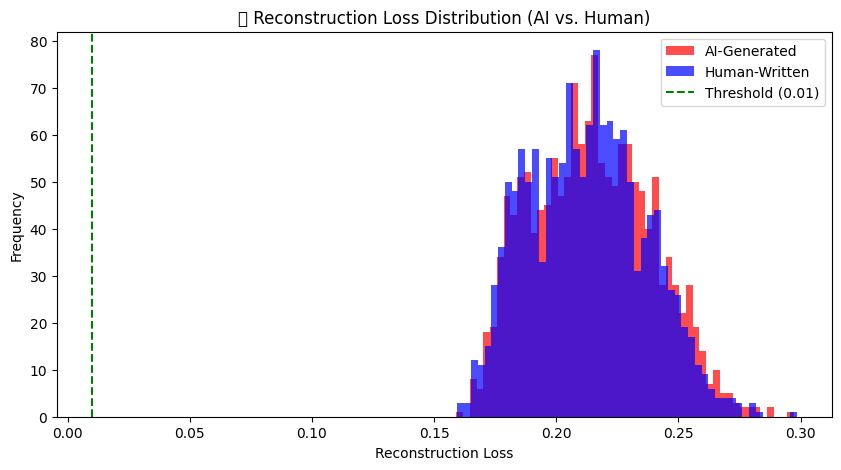

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Compute reconstruction loss on test data
test_reconstruction_loss, test_predictions = detect_ai_text(loaded_model, test_embeddings_tensor)

# Convert numpy array for plotting
true_labels = test_labels_tensor.cpu().numpy()

# Separate AI vs Human losses
ai_losses = test_reconstruction_loss[true_labels == 1]
human_losses = test_reconstruction_loss[true_labels == 0]

# Plot distributions
plt.figure(figsize=(10, 5))
plt.hist(ai_losses, bins=50, alpha=0.7, label="AI-Generated", color="red")
plt.hist(human_losses, bins=50, alpha=0.7, label="Human-Written", color="blue")
plt.axvline(x=0.01, color='green', linestyle="--", label="Threshold (0.01)")
plt.xlabel("Reconstruction Loss")
plt.ylabel("Frequency")
plt.title("📊 Reconstruction Loss Distribution (AI vs. Human)")
plt.legend()
plt.show()


In [36]:
from sklearn.metrics import precision_recall_curve

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(true_labels, test_reconstruction_loss)

# Find best threshold (maximize F1 score)
print(f"🔍 Finding the best threshold...{precision} {recall}")
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"✅ Best threshold found: {best_threshold:.6f}")
print(f"✅ Best F1 score: {np.max(f1_scores):.4f}")

🔍 Finding the best threshold...[0.5        0.49983328 0.49966644 ... 0.         0.         1.        ] [1.         0.99933333 0.99866667 ... 0.         0.         0.        ]
✅ Best threshold found: 0.489466
✅ Best F1 score: nan


C:\Users\ernan\AppData\Local\Temp\ipykernel_28268\3066347102.py:8: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [37]:
# Re-run classification with the best threshold
updated_predictions = (test_reconstruction_loss > best_threshold).astype(int)  # 1 = AI, 0 = Human

# Compute updated evaluation metrics
accuracy = accuracy_score(true_labels, updated_predictions)
precision = precision_score(true_labels, updated_predictions)
recall = recall_score(true_labels, updated_predictions)
f1 = f1_score(true_labels, updated_predictions)

print("\n📊 AI Detection Performance (Updated Threshold):")
print(f"✅ Accuracy: {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall: {recall:.4f}")
print(f"✅ F1 Score: {f1:.4f}")



📊 AI Detection Performance (Updated Threshold):
✅ Accuracy: 0.4997
✅ Precision: 0.0000
✅ Recall: 0.0000
✅ F1 Score: 0.0000
